In [1]:
import pandas as pd
from sklearn import tree, neural_network, model_selection
from sklearn.preprocessing import label_binarize

In [2]:
# importar y ajustar datos
dataset = pd.read_csv("./student-mat.csv", delimiter=";")

# convertir variables 
dataset["school"] = (dataset["school"] == "GP").astype(int)
dataset["sex"] = (dataset["sex"] == "M").astype(int)
dataset["address"] = (dataset["address"] == "U").astype(int)
dataset["famsize"] = (dataset["famsize"] == "GT3").astype(int)
dataset["Pstatus"] = (dataset["Pstatus"] == "T").astype(int)

job_map = {"teacher":0, "health":1, "services":2, "at_home":3, "other":4}
dataset["Mjob"] = dataset["Mjob"].replace(job_map)
dataset["Fjob"] = dataset["Fjob"].replace(job_map)

reason_map = {"home":0, "reputation":1, "course":2, "other":3}
dataset["reason"] = dataset["reason"].replace(reason_map)

guardian_map = {"mother":0, "father":1, "other":2}
dataset["guardian"] = dataset["guardian"].replace(guardian_map)

dataset["schoolsup"] = (dataset["schoolsup"] == "yes").astype(int)
dataset["famsup"] = (dataset["famsup"] == "yes").astype(int)
dataset["paid"] = (dataset["paid"] == "yes").astype(int)
dataset["activities"] = (dataset["activities"] == "yes").astype(int)
dataset["nursery"] = (dataset["nursery"] == "yes").astype(int)
dataset["higher"] = (dataset["higher"] == "yes").astype(int)
dataset["internet"] = (dataset["internet"] == "yes").astype(int)
dataset["romantic"] = (dataset["romantic"] == "yes").astype(int)

# definir target
target = (dataset["G3"] >= 10).astype(int)

In [3]:
from sklearn.model_selection import train_test_split

# crea conjunto de valores eliminando el valor target ( G3 )
X = dataset.copy().drop(["G3"], axis="columns")
y = target

## Clasificación por medio de árbol de decisiones

In [4]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=21)

mejorClassifierScore = 0
mejorClassifier = None
mejorX_train, mejorX_test, mejory_train, mejory_test = (0,0,0,0)

for fold, (train_index, test_index) in enumerate(skf.split(X,y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # creamos el clasificador
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    if(clf.score(X_test, y_test) >= mejorClassifierScore):
        mejorClassifier = clf
        mejorClassifierScore = clf.score(X_test, y_test)
        mejorX_test = X_test
        mejorX_train = X_train
        mejory_test = y_test
        mejory_train = y_train
    print(clf.score(X_test, y_test))
print("Mejor: ", mejorClassifierScore)

0.85
0.925
0.85
0.825
0.875
0.8717948717948718
0.8205128205128205
0.8974358974358975
0.8974358974358975
0.7692307692307693
Mejor:  0.925


<Axes: >

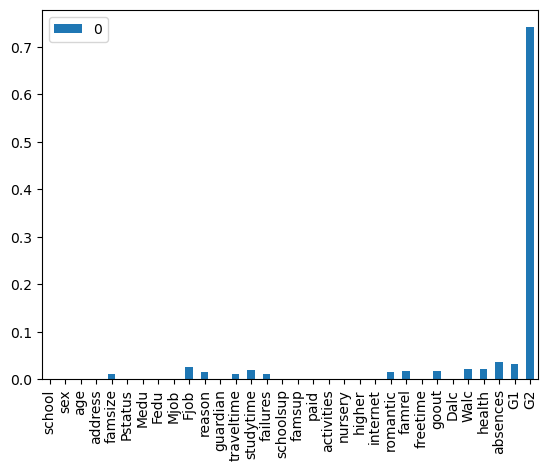

In [5]:
# mostramos los parametros por orden de importancia
importancia_parametros = pd.DataFrame(mejorClassifier.feature_importances_, index=X.columns)
importancia_parametros.plot(kind="bar")

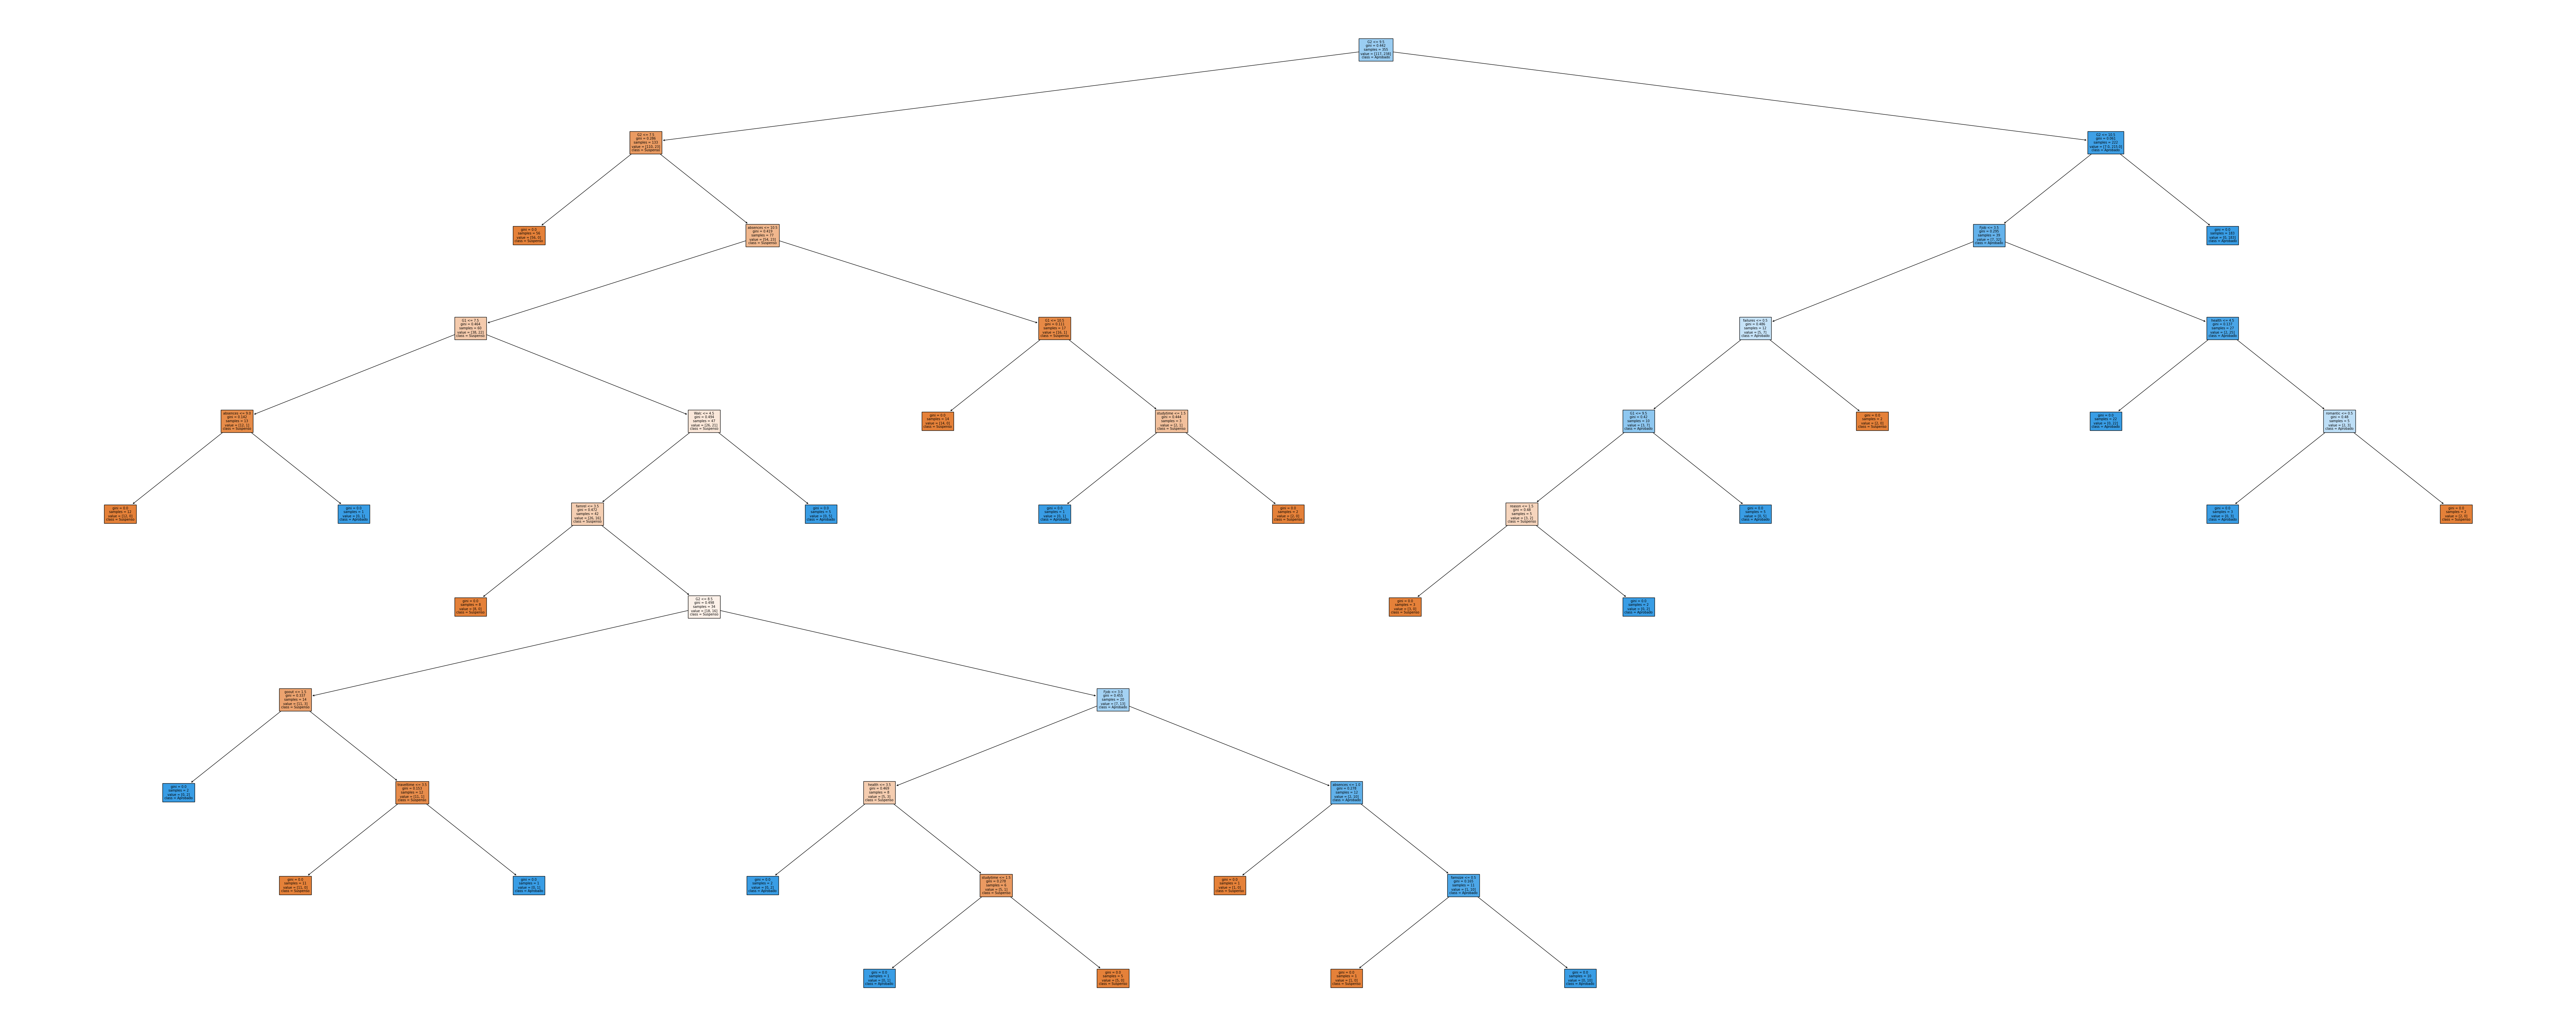

In [6]:
# genero mejor arbol de decisiones
from matplotlib import pyplot as plt 
plt.figure(figsize=(100,40))
tree_plot = tree.plot_tree(mejorClassifier, feature_names=X.columns, filled=True, fontsize=7, class_names={0:"Suspenso", 1:"Aprobado"})

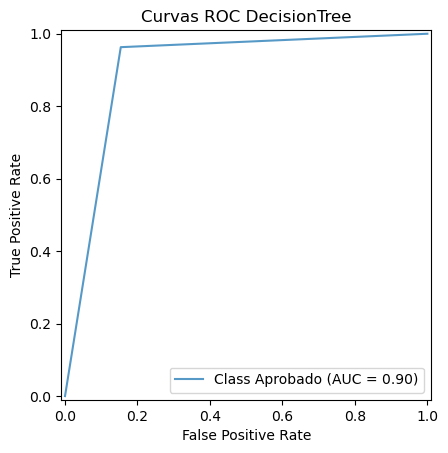

In [7]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

y_prob = mejorClassifier.predict_proba(mejorX_test)[:, 1]
y_test_bin = label_binarize(mejory_test, classes=[0, 1])[:, 0]

fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Class Aprobado').plot(ax=plt.gca(), alpha=0.75)

plt.title('Curvas ROC DecisionTree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Clasificación con redes neuronales

In [8]:
mejorClassifierScore = 0
mejorClassifier = None
mejorX_train, mejorX_test, mejory_train, mejory_test = (0,0,0,0)

for fold, (train_index, test_index) in enumerate(skf.split(X,y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # creamos el clasificador
    clfNueronal = neural_network.MLPClassifier(max_iter=2000)
    clfNueronal.fit(X_train, y_train)

    if(clfNueronal.score(X_test, y_test) >= mejorClassifierScore):
        mejorClassifier = clfNueronal
        mejorClassifierScore = clfNueronal.score(X_test, y_test)
        mejorX_test = X_test
        mejorX_train = X_train
        mejory_test = y_test
        mejory_train = y_train
    print(clfNueronal.score(X_test, y_test))
print("Mejor: ", mejorClassifierScore)




0.85
0.975
0.9
0.775
0.9
0.9487179487179487
0.8461538461538461
0.8205128205128205
0.9230769230769231
0.9487179487179487
Mejor:  0.975


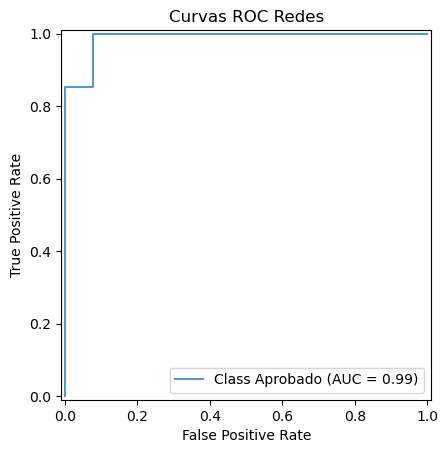

In [9]:
y_prob = mejorClassifier.predict_proba(mejorX_test)[:, 1]
y_test_bin = label_binarize(mejory_test, classes=[0, 1])[:, 0]

fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Class Aprobado').plot(ax=plt.gca(), alpha=0.75)

plt.title('Curvas ROC Redes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Analisis
Podemos observar como la precisión del primer modelo empleado usando DecisionTree es cercana a 90% mientras que la precisión conseguida con un modelo de redes neuronales obtiene un resultado cercano al 100%.